In [31]:
!pip install streamlit==1.38.0
!pip install joblib==1.4.2
!pip install scikit-learn==1.5.2
!pip install matplotlib==3.9.2
!pip install xgboost==2.1.1

In [32]:
!pip install plotly==5.24.1

In [33]:
import pandas as pd

In [34]:
from google.colab import files
uploaded = files.upload()

Saving weatherAUS.csv to weatherAUS (1).csv


In [35]:
files=list(uploaded.keys())[0]

In [36]:
df = pd.read_csv(files)

In [37]:
!pip install tensorflow

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix,
                            ConfusionMatrixDisplay, RocCurveDisplay)
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)

In [39]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [40]:
# Basic info
print("\n=== Dataset Info ===")
print(df.info())


=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9a

In [41]:
# Missing values analysis
print("\n=== Missing Values ===")
missing = df.isnull().mean().sort_values(ascending=False)
print(missing[missing > 0])


=== Missing Values ===
Sunshine         0.480098
Evaporation      0.431665
Cloud3pm         0.408071
Cloud9am         0.384216
Pressure9am      0.103568
Pressure3pm      0.103314
WindDir9am       0.072639
WindGustDir      0.070989
WindGustSpeed    0.070555
Humidity3pm      0.030984
WindDir3pm       0.029066
Temp3pm          0.024811
RainTomorrow     0.022460
Rainfall         0.022419
RainToday        0.022419
WindSpeed3pm     0.021050
Humidity9am      0.018246
WindSpeed9am     0.012148
Temp9am          0.012148
MinTemp          0.010209
MaxTemp          0.008669
dtype: float64


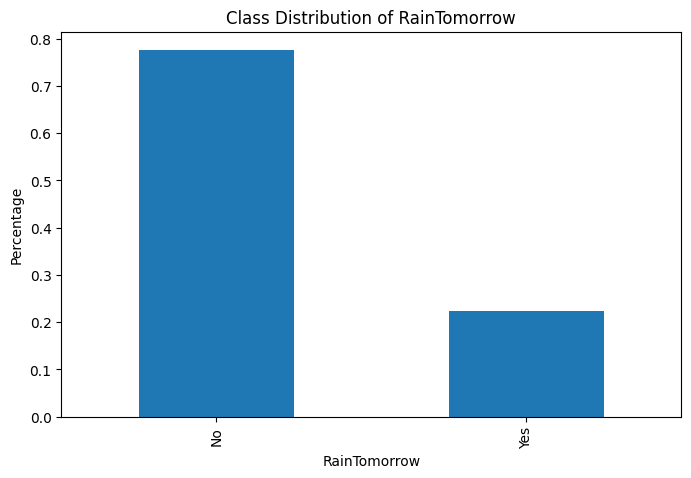

In [42]:
# Target distribution
plt.figure(figsize=(8,5))
df['RainTomorrow'].value_counts(normalize=True).plot(kind='bar')
plt.title('Class Distribution of RainTomorrow')
plt.ylabel('Percentage')
plt.show()
plt.savefig('class_distribution.png')
plt.close()


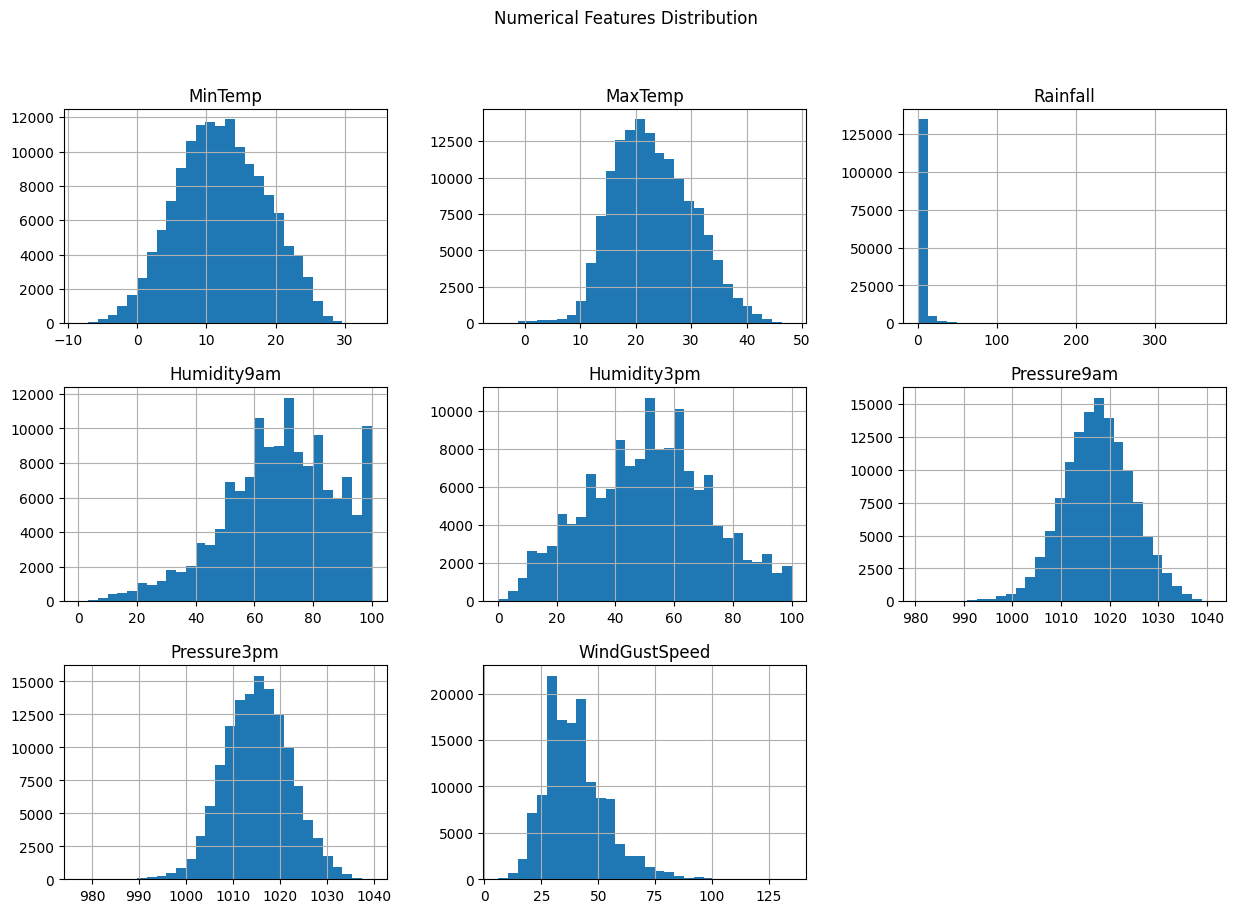

In [43]:
# Numerical features distribution
num_cols = ['MinTemp', 'MaxTemp', 'Rainfall', 'Humidity9am', 'Humidity3pm',
            'Pressure9am', 'Pressure3pm', 'WindGustSpeed']
df[num_cols].hist(bins=30, figsize=(15,10))
plt.suptitle('Numerical Features Distribution')
plt.show()
plt.savefig('numerical_distribution.png')
plt.close()

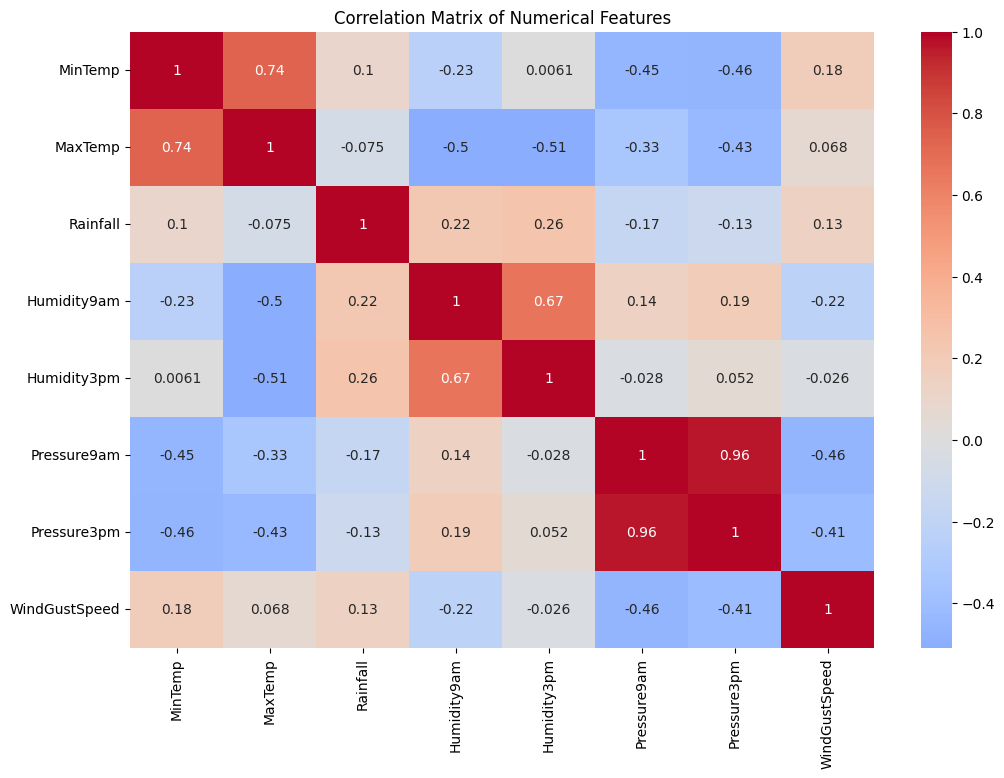

In [44]:
# Correlation analysis
plt.figure(figsize=(12,8))
corr_matrix = df[num_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()
plt.savefig('correlation_matrix.png')
plt.close()

In [45]:
# Drop columns with high missingness or leakage risk
df = df.drop(columns=['Date', 'Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm', 'RainToday'])

# Handle missing values
num_cols = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am',
            'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm',
            'Temp9am', 'Temp3pm']
cat_cols = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'Location']

In [46]:
# Numerical imputation
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Categorical imputation
df[cat_cols] = df[cat_cols].fillna('Missing')

In [47]:
# Fix impossible values
df['Humidity9am'] = df['Humidity9am'].clip(1, 100)
df['Humidity3pm'] = df['Humidity3pm'].clip(1, 100)

# Target encoding
df['RainTomorrow'] = df['RainTomorrow'].map({'No':0, 'Yes':1})

# Feature engineering
df['TempDiff'] = df['MaxTemp'] - df['MinTemp']
df['HumidityDiff'] = df['Humidity9am'] - df['Humidity3pm']

# Categorical encoding
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [48]:
# Final check
print("\n=== After Preprocessing ===")
print(f"Remaining missing values: {df.isnull().sum().sum()}")
print(f"Final shape: {df.shape}")


=== After Preprocessing ===
Remaining missing values: 3267
Final shape: (145460, 111)


In [49]:
# Check for NaN in target
print("NaN values in RainTomorrow:", df['RainTomorrow'].isna().sum())

# Drop rows where RainTomorrow is NaN
df = df.dropna(subset=['RainTomorrow'])

NaN values in RainTomorrow: 3267


In [50]:
# Split data
X = df.drop(columns=['RainTomorrow'])
y = df['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [51]:
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [52]:
# Calculate class weights
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])
print(f"\nClass weight ratio: {scale_pos_weight:.2f}")


Class weight ratio: 3.46


In [53]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric='logloss', random_state=42)
}


=== Training Logistic Regression ===


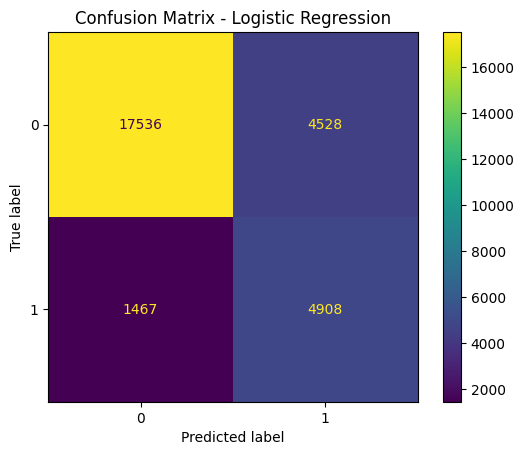

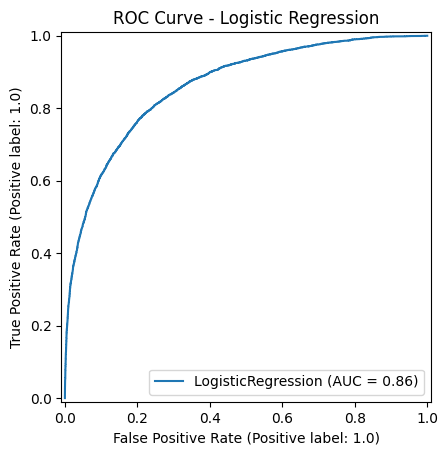


=== Training Random Forest ===


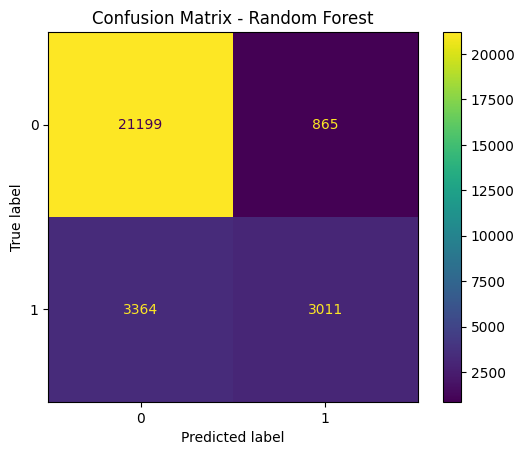

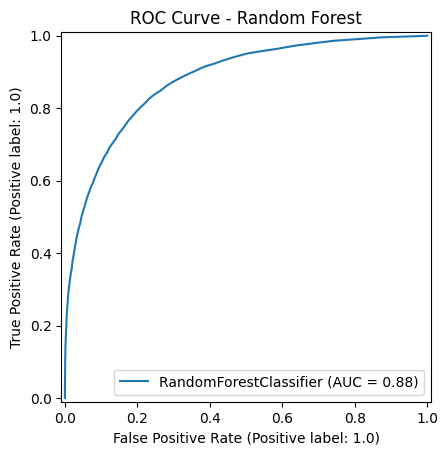


=== Training XGBoost ===


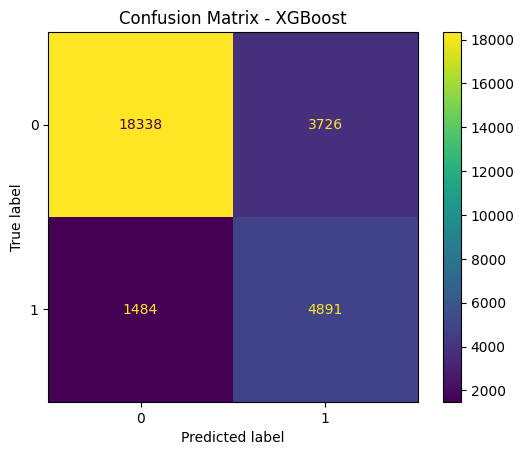

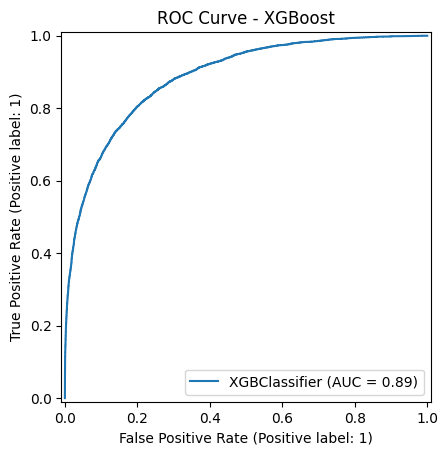

In [54]:
# Train and evaluate models
results = {}
for name, model in models.items():
    print(f"\n=== Training {name} ===")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Store metrics
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred)
    }

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix - {name}')
    plt.show()
    plt.savefig(f'confusion_matrix_{name.lower().replace(" ", "_")}.png')
    plt.close()

    # ROC curve
    RocCurveDisplay.from_estimator(model, X_test_scaled, y_test)
    plt.title(f'ROC Curve - {name}')
    plt.show()
    plt.savefig(f'roc_curve_{name.lower().replace(" ", "_")}.png')
    plt.close()


In [55]:
# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print("\n=== Model Performance ===")
print(results_df)


=== Model Performance ===
                     Accuracy  Precision    Recall        F1   ROC-AUC
Logistic Regression  0.789198   0.520136  0.769882  0.620834  0.782331
Random Forest        0.851296   0.776832  0.472314  0.587455  0.716555
XGBoost              0.816801   0.567599  0.767216  0.652481  0.799172


In [56]:
# Save best model
best_model = models['XGBoost']
joblib.dump(best_model, 'best_model.joblib')
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [57]:
# Tune XGBoost (our best performing model)
print("\n=== Hyperparameter Tuning for XGBoost ===")
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb = XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric='logloss', random_state=42)
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='recall',
    cv=StratifiedKFold(n_splits=5),
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best recall score: {grid_search.best_score_:.4f}")

# Evaluate tuned model
tuned_model = grid_search.best_estimator_
y_pred_tuned = tuned_model.predict(X_test_scaled)
print("\n=== Tuned Model Performance ===")
print(f"Recall: {recall_score(y_test, y_pred_tuned):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_tuned):.4f}")

# Save tuned model
joblib.dump(tuned_model, 'tuned_model.joblib')


=== Hyperparameter Tuning for XGBoost ===
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.2, 'max_depth': 5, 'subsample': 1.0}
Best recall score: 0.7707

=== Tuned Model Performance ===
Recall: 0.7765
ROC-AUC: 0.7987


['tuned_model.joblib']

In [58]:
# Neural Network Model
print("\n=== Neural Network Implementation ===")
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(name='recall')]
)

early_stop = EarlyStopping(monitor='val_recall', patience=5, mode='max', restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


=== Neural Network Implementation ===
Epoch 1/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7980 - loss: 0.4462 - recall: 0.3142 - val_accuracy: 0.8520 - val_loss: 0.3484 - val_recall: 0.4884
Epoch 2/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8446 - loss: 0.3643 - recall: 0.4824 - val_accuracy: 0.8579 - val_loss: 0.3402 - val_recall: 0.5017
Epoch 3/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8497 - loss: 0.3529 - recall: 0.5021 - val_accuracy: 0.8571 - val_loss: 0.3350 - val_recall: 0.4884
Epoch 4/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8503 - loss: 0.3499 - recall: 0.5025 - val_accuracy: 0.8572 - val_loss: 0.3295 - val_recall: 0.4950
Epoch 5/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8550 - loss: 0.3407 - recall: 0.5161 - val_accuracy: 0.8578 - val_loss: 0.3307 - val_recall: 0.4696
Epoch 6/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8554 - loss: 0.3395 - recall: 0.5105 - val_accuracy: 

In [29]:
# Evaluate NN
nn_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")
results['Neural Network'] = {
    'Accuracy': accuracy_score(y_test, nn_pred),
    'Precision': precision_score(y_test, nn_pred),
    'Recall': recall_score(y_test, nn_pred),
    'F1': f1_score(y_test, nn_pred),
    'ROC-AUC': roc_auc_score(y_test, nn_pred)
}

# Update results
results_df = pd.DataFrame(results).T
print("\n=== Final Model Performance ===")
print(results_df)

889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

=== Final Model Performance ===
                     Accuracy  Precision    Recall        F1   ROC-AUC
Logistic Regression  0.789198   0.520136  0.769882  0.620834  0.782331
Random Forest        0.851296   0.776832  0.472314  0.587455  0.716555
XGBoost              0.816801   0.567599  0.767216  0.652481  0.799172
Neural Network       0.858926   0.794125  0.500392  0.613934  0.731455


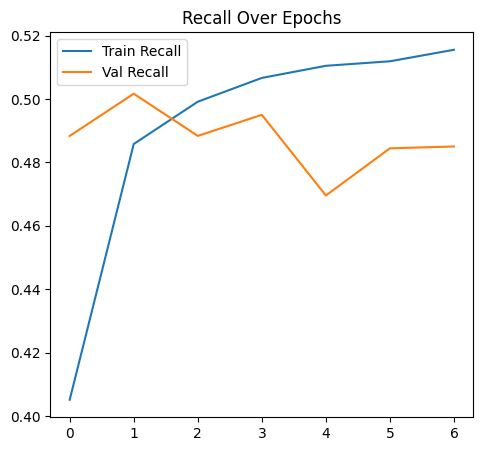

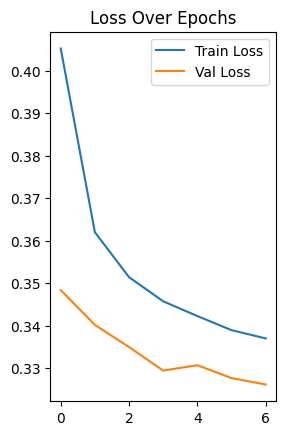

In [59]:
# Plot training history
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Val Recall')
plt.title('Recall Over Epochs')
plt.legend()
plt.show()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()
plt.savefig('nn_training_history.png')
plt.close()

In [60]:
# Enhanced Neural Network Model with More Layers
print("\n=== Enhanced Neural Network Implementation ===")
enhanced_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(96, activation='relu'),  # Additional layer
    Dropout(0.15),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(32, activation='relu'),  # Additional layer
    Dropout(0.05),
    Dense(1, activation='sigmoid')
])

# Using a slightly lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

enhanced_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall()]
)

# Callbacks
early_stop = EarlyStopping(
    monitor='val_recall',
    patience=7,
    mode='max',
    restore_best_weights=True,
    min_delta=0.001
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_recall',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    mode='max'
)

history = enhanced_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=128,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Evaluate Enhanced NN
enhanced_nn_pred = (enhanced_model.predict(X_test_scaled) > 0.5).astype("int32")
results['Enhanced Neural Network'] = {
    'Accuracy': accuracy_score(y_test, enhanced_nn_pred),
    'Precision': precision_score(y_test, enhanced_nn_pred),
    'Recall': recall_score(y_test, enhanced_nn_pred),
    'F1': f1_score(y_test, enhanced_nn_pred),
    'ROC-AUC': roc_auc_score(y_test, enhanced_nn_pred)
}

# Update results
results_df = pd.DataFrame(results).T
print("\n=== Final Model Performance ===")
print(results_df)


=== Enhanced Neural Network Implementation ===
Epoch 1/100
711/711 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8067 - loss: 0.4414 - recall: 0.2725 - val_accuracy: 0.8517 - val_loss: 0.3501 - val_recall: 0.5075 - learning_rate: 5.0000e-04
Epoch 2/100
711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8448 - loss: 0.3625 - recall: 0.4836 - val_accuracy: 0.8579 - val_loss: 0.3383 - val_recall: 0.5252 - learning_rate: 5.0000e-04
Epoch 3/100
711/711 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8502 - loss: 0.3515 - recall: 0.5040 - val_accuracy: 0.8587 - val_loss: 0.3379 - val_recall: 0.5242 - learning_rate: 5.0000e-04
Epoch 4/100
711/711 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8534 - loss: 0.3462 - recall: 0.5123 - val_accuracy: 0.8607 - val_loss: 0.3317 - val_recall: 0.5453 - learning_rate: 5.0000e-04
Epoch 5/100
711/711 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8573 - loss: 0.3369 - recall: 0.5335 - val_accuracy: 0.8599 - val_loss: 0.3305 - val_recall: 0.5298 - le

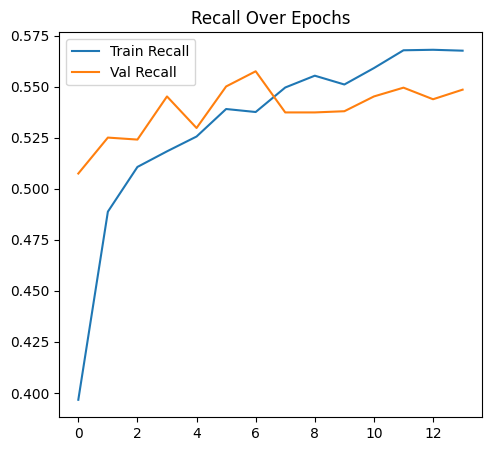

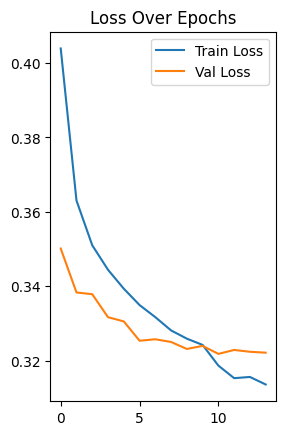

In [61]:
# Plot training history
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Val Recall')
plt.title('Recall Over Epochs')
plt.legend()
plt.show()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()
plt.savefig('nn_training_history.png')
plt.close()

In [ ]:
from google.colab import files
files.download('best_model.joblib')
files.download('scaler.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>